# Klasifikasi Sampah
## Sampah daur ulang dan yang tidak bisa di daur ulang



In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from torchvision import datasets, transforms as T
from tensorflow import keras
from PIL import Image
from pathlib import Path
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
import seaborn as sns


In [2]:
# !pip install --upgrade tensorflow tensorflowjs


In [3]:
# import tensorflow as tf
# import tensorflowjs as tfjs
# print("TensorFlow version:", tf.__version__)
# print("TensorFlow.js version:", tfjs.__version__)

# import tensorflowjs as tfjs
# print("TensorFlow.js is ready for conversion!")



In [4]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [5]:
# !nvidia-smi


In [6]:
# import tensorflow as tf

# print("Devices available:")
# print(tf.config.list_physical_devices('GPU'))

# # Pastikan GPU dapat digunakan
# if tf.config.list_physical_devices('GPU'):
#     print("Using GPU for training")
# else:
#     print("Using CPU for training")


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fathurrahmanalfarizy/sampah-daur-ulang")

print("Path to dataset files:", path)

100%|██████████| 98.5M/98.5M [00:01<00:00, 99.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5


In [8]:

main_dir = os.path.join(path, 'DATASETS')  # Sesuaikan dengan nama folder dataset jika berbeda

# Mengecek apakah direktori dataset ada
if os.path.exists(main_dir):
    print(f"Dataset ditemukan di: {main_dir}")
else:
    print("Dataset tidak ditemukan di path yang diberikan.")

# Menggunakan os untuk melihat isi dataset (kumpulan kelas)
dataset_classes = os.listdir(main_dir)

# Menampilkan nama kelas yang ada dalam dataset
print("\nKelas-kelas yang ada dalam dataset:")
for idx, class_name in enumerate(dataset_classes, 1):
    print(f"{idx}. {class_name}")

# Menghitung jumlah gambar di masing-masing kelas
for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)
    # Menghitung jumlah gambar dalam subfolder kelas
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
        print(f"Jumlah gambar di kelas '{class_name}': {num_images}")


Dataset ditemukan di: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5/DATASETS

Kelas-kelas yang ada dalam dataset:
1. Plastik
2. Logam
3. Residu
4. Kertas
5. Kardus
6. Kaca
Jumlah gambar di kelas 'Plastik': 1256
Jumlah gambar di kelas 'Logam': 1210
Jumlah gambar di kelas 'Residu': 1002
Jumlah gambar di kelas 'Kertas': 1807
Jumlah gambar di kelas 'Kardus': 624
Jumlah gambar di kelas 'Kaca': 1110


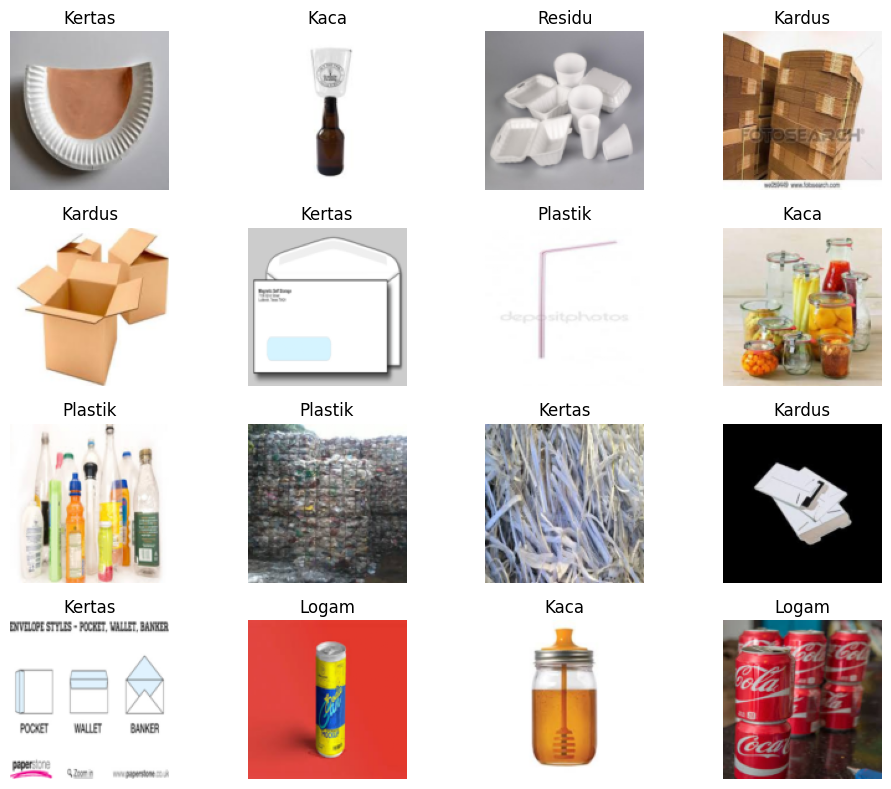

In [9]:


# Transformasi dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize gambar
    transforms.ToTensor()          # Konversi ke tensor
])

# Memuat dataset menggunakan ImageFolder
dataset = ImageFolder(root=main_dir, transform=transform)

# Membuat DataLoader untuk batch
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Menampilkan batch pertama
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Plot batch gambar
def show_batch(images, labels, class_names):
    fig, axes = plt.subplots(4, 4, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))  # Permute tensor ke format HWC
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Mendapatkan kelas dari dataset
class_names = dataset.classes

# Menampilkan gambar batch
show_batch(images, labels, class_names)


In [10]:


# Direktori pembagian dataset
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

# Membuat direktori untuk train, val, dan test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membagi dataset ke dalam train-test, dan validasi diambil dari train
dataset_classes = os.listdir(main_dir)
for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)

    if os.path.isdir(class_dir):
        # List semua gambar dalam subfolder kelas
        images = [f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
        print(f"\nJumlah gambar di kelas '{class_name}': {len(images)}")

        # Split dataset menjadi train (80%) dan test (20%)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Split train menjadi train dan val (20% dari train)
        train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

        # Membuat subfolder untuk setiap kelas di train, val, dan test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Pindahkan data ke folder train
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))

        # Pindahkan data ke folder val
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, class_name, img))

        # Pindahkan data ke folder test
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, class_name, img))

# Menghitung jumlah data di setiap set
def count_images_in_directory(directory):
    total_images = 0
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            total_images += len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
    return total_images

# Hitung jumlah data di train, val, dan test
num_train = count_images_in_directory(train_dir)
num_val = count_images_in_directory(val_dir)
num_test = count_images_in_directory(test_dir)

print("\nJumlah data di setiap set:")
print(f"Train: {num_train} images")
print(f"Validation: {num_val} images")
print(f"Test: {num_test} images")



Jumlah gambar di kelas 'Plastik': 1256

Jumlah gambar di kelas 'Logam': 1210

Jumlah gambar di kelas 'Residu': 1002

Jumlah gambar di kelas 'Kertas': 1807

Jumlah gambar di kelas 'Kardus': 624

Jumlah gambar di kelas 'Kaca': 1110

Jumlah data di setiap set:
Train: 4482 images
Validation: 1123 images
Test: 1404 images


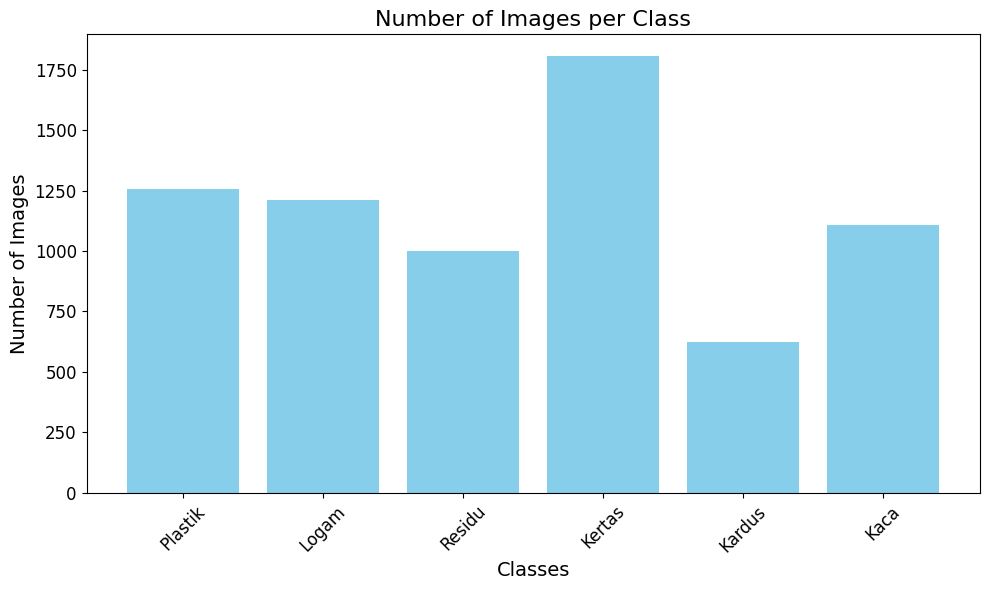

In [11]:

# Mengecek apakah direktori dataset ada
if not os.path.exists(main_dir):
    raise FileNotFoundError(f"Dataset tidak ditemukan di: {main_dir}")

# Menggunakan os untuk menghitung jumlah gambar di masing-masing kelas
class_counts = {}
dataset_classes = os.listdir(main_dir)

for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
        class_counts[class_name] = num_images

# Menampilkan hasil dalam diagram batang
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Class', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [12]:
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")


Train directory: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5/train
Validation directory: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5/val
Test directory: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5/test


In [24]:


# === Bagian 1: Dataset Preprocessing ===

# Dataset preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalisasi nilai piksel ke [0,1]
    shear_range=0.2,              # Shear augmentasi
    zoom_range=0.2,               # Zoom augmentasi
    rotation_range=30,            # Rotasi gambar hingga 30 derajat
    brightness_range=[0.8, 1.2],  # Variasi kecerahan
    horizontal_flip=True          # Flip horizontal
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi untuk validasi
img_h = 128
img_w = 128
# Memuat data dari folder train, val, dan test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_h, img_w),  # Resolusi input ke CNN
    batch_size=32,           # Ukuran batch
    class_mode='categorical' # Klasifikasi multi-kelas
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_h, img_w),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_h, img_w),
    batch_size=32,
    class_mode='categorical'
)




Found 4482 images belonging to 6 classes.
Found 1123 images belonging to 6 classes.
Found 1404 images belonging to 6 classes.


In [27]:
# === Bagian 2: Definisi Model CNN ===

# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(train_generator.class_indices), activation='softmax')
# ])

# === Bagian 2: Definisi Model CNN === atau pakai rest net nanti

# model = models.Sequential([
#     tf.keras.Input(shape=(150, 150, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu',),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'), # jika dense dikurangin maka o.6
#     layers.Dropout(0.3), #0.3/0.2  # 0.3 = accuracy: 0.7996 - loss: 0.5488 - val_accuracy: 0.6616   # 0.5 dengan epoch 30, train accurasi = 0.75,
#     #layers.Dense(len(train_generator.class_indices), activation='softmax')
#     layers.Dense(6, activation='softmax')
# ])

## akurasi test 0.62
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'), # jika dense dikurangin maka o.6
#     layers.Dropout(0.3), #0.3/0.2  # 0.3 = 0.7 # 0.5 dengan epoch 30, train accurasi = 0.75
#     layers.Dense(len(train_generator.class_indices), activation='softmax')
# ])


# akurasi test 0.62
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'), #coba jika desne 1 ni di comen
#     #layers.Dropout(0.5),
#     layers.Dense(len(train_generator.class_indices), activation='softmax')
# ])

# Load pretrained MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# Add custom layers
inputs = layers.Input(shape=(img_h, img_w, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x) # over vit dengan beda 20% jika tanpa Dropout
outputs = layers.Dense(6, activation='softmax')(x)

model = models.Model(inputs, outputs)



model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,756,742 (14.33 MB)

 Trainable params: 3,734,854 (14.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.5596 - loss: 1.3699 - val_accuracy: 0.6634 - val_loss: 1.1082
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.7506 - loss: 0.7080 - val_accuracy: 0.7266 - val_loss: 0.8709
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.7868 - loss: 0.6146 - val_accuracy: 0.7106 - val_loss: 1.1300
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.8047 - loss: 0.5582 - val_accuracy: 0.7614 - val_loss: 0.6938
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.8236 - loss: 0.5172 - val_accuracy: 0.8201 - val_loss: 0.5868
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.8496 - loss: 0.4179 - val_accuracy: 0.8085 - val_loss: 0.6120
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.8646 - loss: 0.3918 - val_accuracy: 0.7863 - val_loss: 0.6595
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.8703 - loss: 0.4127 - val_accuracy: 0.848

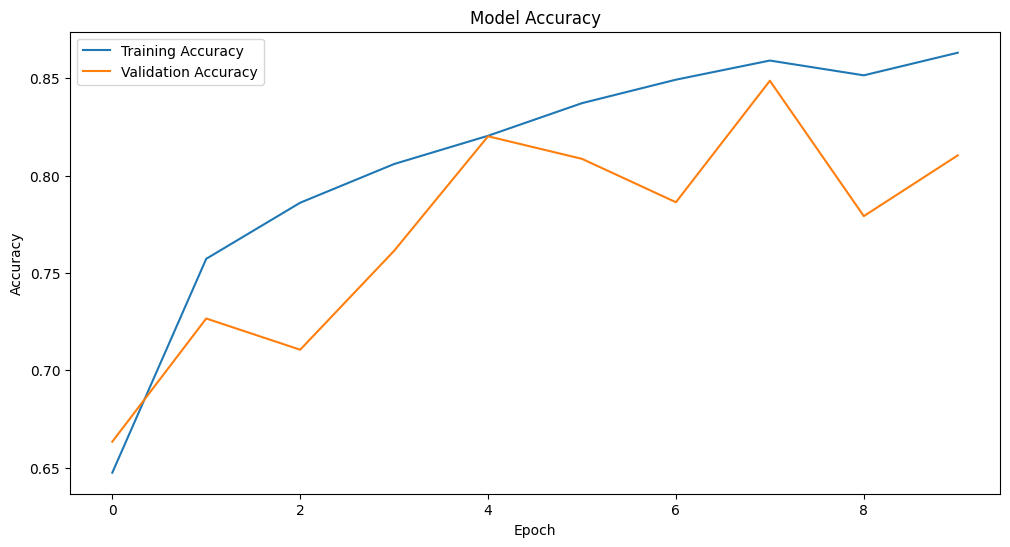

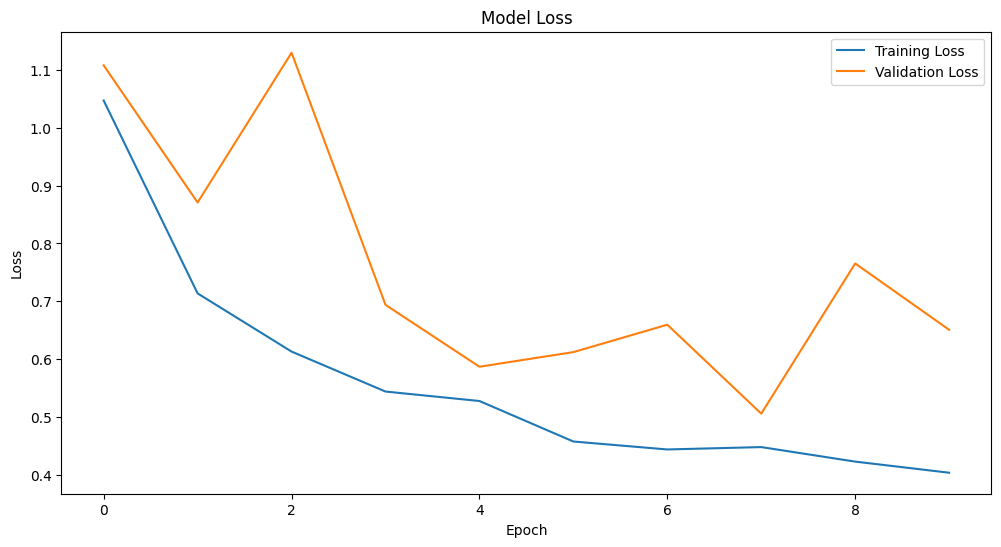

In [28]:
# === Bagian 3: Compile Model ===

model.compile(optimizer=Adam(learning_rate=0.001), # lr reducer
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Bagian 4: Train Model ===

early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True) #monitor - akurasi atau auc kalau pakai auc

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# === Bagian 5: Evaluate Model ===

loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy:.2f}")

# === Bagian 6: Visualisasi Hasil Training ===

import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - accuracy: 0.8311 - loss: 0.5456
Test Loss: 0.62
Test Accuracy: 0.82
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step

Classification Report:
              precision    recall  f1-score   support

        Kaca       0.16      0.18      0.17       222
      Kardus       0.13      0.09      0.10       125
      Kertas       0.27      0.28      0.27       362
       Logam       0.19      0.21      0.20       242
     Plastik       0.16      0.15      0.15       252
      Residu       0.16      0.14      0.15       201

    accuracy                           0.19      1404
   macro avg       0.18      0.17      0.17      1404
weighted avg       0.19      0.19      0.19      1404



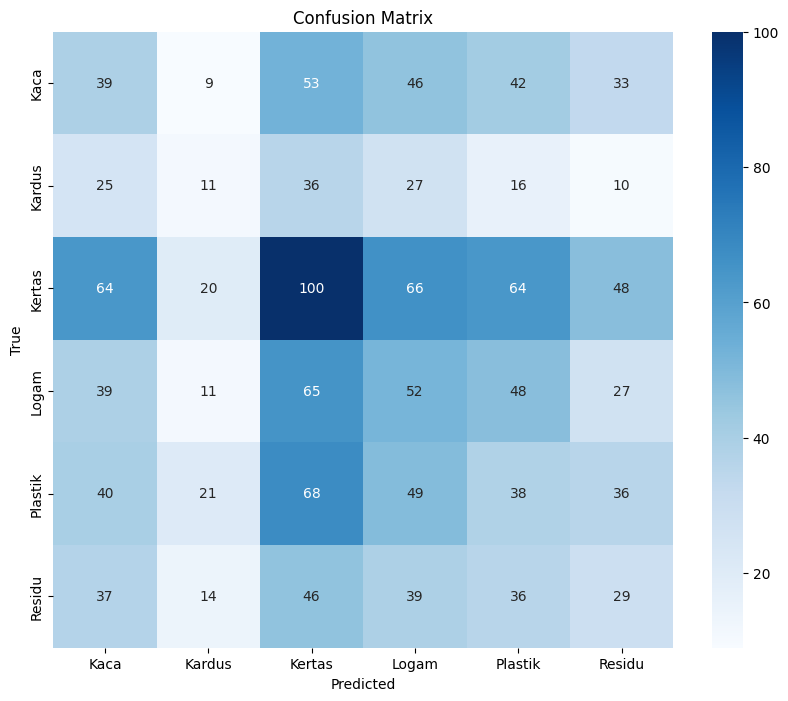

In [31]:


# Lakukan evaluasi pada data uji
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Prediksi pada data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Buat laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Matriks Kebingungan
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


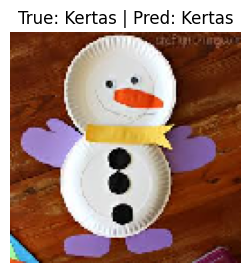

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


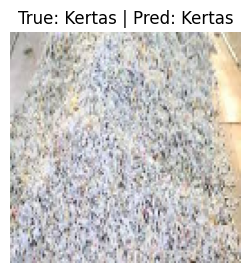

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


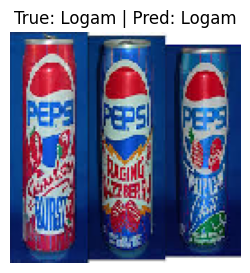

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


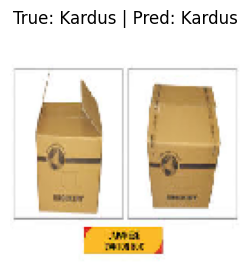

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


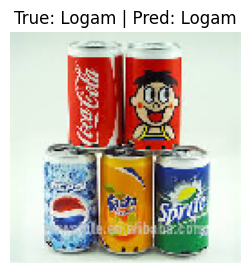

In [35]:


# Function to display image and its prediction
def display_random_predictions(generator, model, num_images=5):
    # Convert class indices to a list for easy indexing
    class_labels = list(generator.class_indices.keys())

    # Get a batch of images and labels
    images, labels = next(iter(generator))

    # Loop through the number of images you want to display
    for i in range(num_images):
        image = images[i]
        label = labels[i]

        # Get model predictions for the image
        prediction = model.predict(np.expand_dims(image, axis=0))  # Model expects batch dimension
        predicted_class = np.argmax(prediction, axis=-1)[0]  # Get the class index with the highest probability (scalar value)
        true_class = np.argmax(label, axis=-1)  # Get the true class index

        # Display the image with its true label and predicted label
        plt.figure(figsize=(3,3))
        plt.imshow(image)
        plt.title(f"True: {class_labels[true_class]} | Pred: {class_labels[predicted_class]}")
        plt.axis('off')
        plt.show()

# Call the function to display random predictions
display_random_predictions(validation_generator, model, num_images=5)


In [36]:
import tensorflow as tf
from google.colab import files

# Simpan model Keras (jika model belum disimpan)
model.save('my_model.h5')

# Memuat model Keras yang sudah disimpan
model = tf.keras.models.load_model('my_model.h5')

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Opsional: Optimisasi model (misalnya quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Lakukan konversi
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file .tflite
tflite_model_path = '/content/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Download file .tflite
files.download(tflite_model_path)


Saved artifact at '/tmp/tmphru4ad74'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_13')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135555058217232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058218640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555158894096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058289824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058292112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555160264192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058290528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058287360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058291584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058288064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135555058297

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# # Simpan model TensorFlow ke format TensorFlow.js
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, "path_to_save_tfjs_model1")
